# Проект по статистическому анализу данных:<br>**«Исследование подписок сервиса по прокату самокатов»**

Вы аналитик популярного сервиса аренды самокатов GoFast. Вам передали данные о некоторых пользователях из нескольких городов, а также об их поездках. Проанализируйте данные и проверьте некоторые гипотезы, которые могут помочь бизнесу вырасти.</p>

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

- без подписки
  - абонентская плата отсутствует;
  - стоимость одной минуты поездки — 8 рублей;
  - стоимость старта (начала поездки) — 50 рублей;
  
  
- с подпиской Ultra
  - абонентская плата — 199 рублей в месяц;
  - стоимость одной минуты поездки — 6 рублей;
  - стоимость старта — бесплатно.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats as st

In [2]:
COLOR = sns.color_palette('GnBu')

## Шаг 1. Загрузка данных

### Загрузка данных

In [3]:
users_df = pd.read_csv('/datasets/users_go.csv')
rides_df = pd.read_csv('/datasets/rides_go.csv')
subs_df = pd.read_csv('/datasets/subscriptions_go.csv')

### Изучение данных

Информация о пользователях:

In [4]:
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Информация о поездках:

In [6]:
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Информация о подписках:

In [8]:
subs_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Вывод

Были созданы три датафрейма:
- `users_df` со списком пользоватей,
- `rides_df` со списком поездок,
- `subs_df` с вариантами подписок.

Пропуски в данных не обнаружены, колонка `date` в датафрейме `rides_df`, нуждается в приведении в тип данных `datetime`.

## Шаг 2. Предобработка данных

### Приведение столбца `date` к типу данных `dateime`

In [10]:
rides_df['date'] = pd.to_datetime(rides_df['date'], format="%Y-%m-%d")

###  Создайте столбеца с номером месяца

In [11]:
display(rides_df['date'].min())
rides_df['date'].max()

Timestamp('2021-01-01 00:00:00')

Timestamp('2021-12-30 00:00:00')

В датафрейме содержатся данные за 2021 год.

In [12]:
rides_df['month'] = rides_df['date'].dt.month

In [13]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 635.3 KB


In [14]:
rides_df.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


### Проверка на наличие пропущенных значений и дубликатов

In [15]:
users_df.duplicated().sum()

31

In [16]:
users_df.loc[users_df.duplicated()]

,user_id,name,age,city,subscription_type
1534,293,Агата,26,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
1536,909,Константин,20,Екатеринбург,free
1537,403,Полина,19,Сочи,ultra
1538,908,Рустам,30,Тюмень,free
1539,43,Стефания,22,Омск,ultra
1540,127,Павел,25,Пятигорск,ultra
1541,659,Злата,27,Ростов-на-Дону,ultra
1542,204,Руслан,30,Пятигорск,ultra
1543,153,Герман,23,Москва,ultra


В датафрейме `users_df` найден 31 дубликат. Все дубликаты находятся в конце таблицы, возможно их появление связано с ошибкой при выгрузке или при передаче данных.

In [17]:
users_df = users_df.drop_duplicates()

In [18]:
users_df.duplicated().sum()

0

In [19]:
rides_df.duplicated().sum()

0

### Вывод

На данном этапе столбец `date` датафрейма `rides_df` был приведен к типу данных `datetime`, так же в датафрейме `rides_df` был создан новый столбец `month` с номером месяца из столбца `date`. Были удалены дубликаты в фрейме `users_df`, вызванные, судя по всему, ошибкой при выгрузке или передаче данных.

## Шаг 3. Исследовательский анализ данных

### Частота встречаемости городов

In [20]:
users_df['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

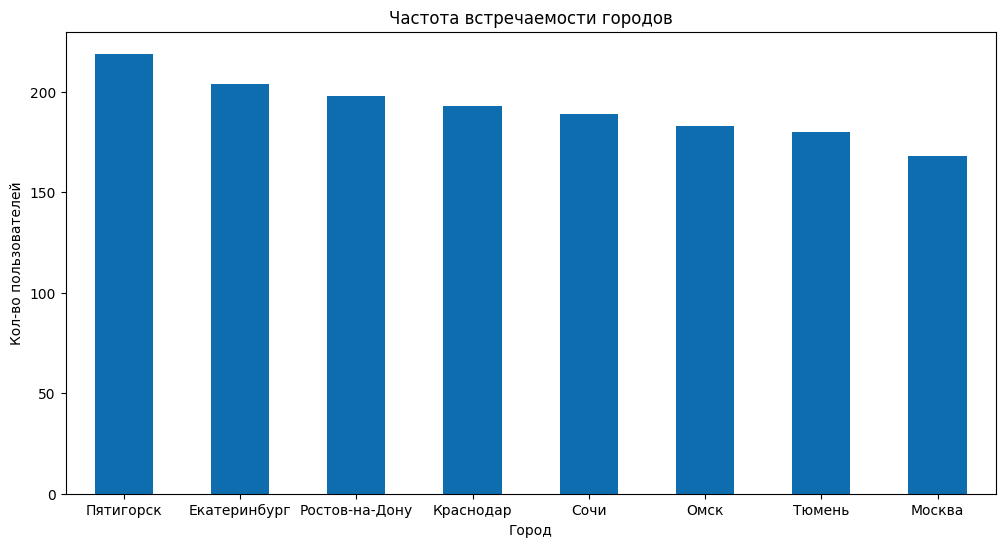

In [21]:
cities_table = (
    users_df
    .pivot_table(
        index='city',
        values='user_id',
        aggfunc='count'
    )
    .sort_values(
        by='user_id',
        ascending = False
    )
    .plot(
        kind='bar',
        xlabel='Город',
        ylabel='Кол-во пользователей',
        title='Частота встречаемости городов',
        legend=False,
        rot = 0,
        color=COLOR[5],
        figsize=(12, 6)
    ))

Большенство пользователей из южных городов или городов за Уралом, столица находиться на последнем месте по количеству пользователей.

### Соотношение пользователей с подпиской и без подписки

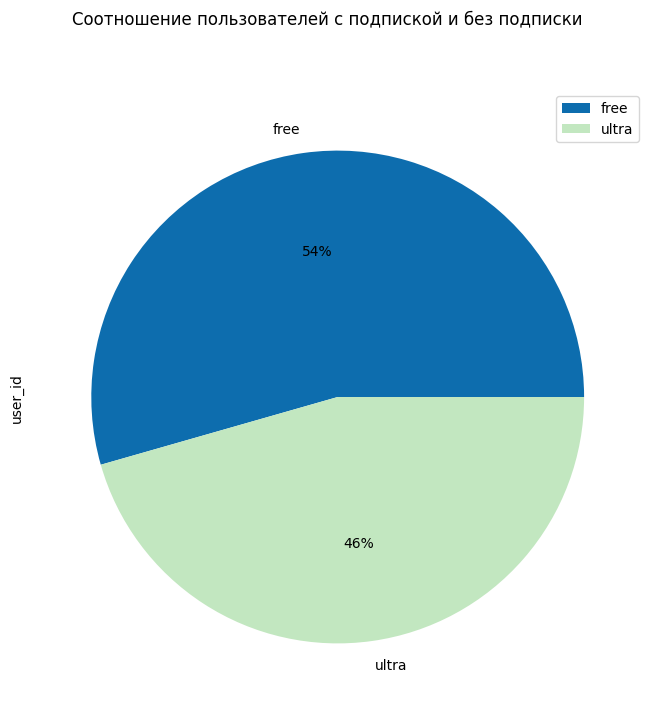

In [22]:
subs_pie = (
    users_df
    .pivot_table(
        index='subscription_type',
        values='user_id',
        aggfunc='count'
    )
    .plot(
        kind='pie',
        autopct='%1.0f%%',
        subplots=True,
        figsize=(8, 8),
        colors=[COLOR[5], COLOR[1]],
        title = 'Cоотношение пользователей с подпиской и без подписки'
    ))

Разница между пользователями с подпиской и без подписки не велика. Пользователей с подпиской всего на 8% меньше чем без подпиской, 46% против 54% соответственно.

### Возраст пользователей

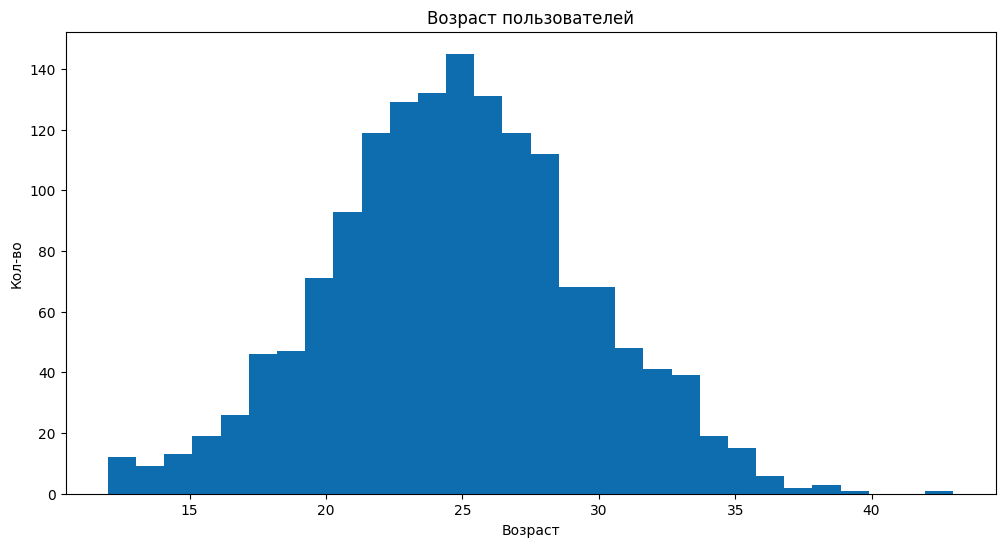

In [23]:
users_df['age'].plot(kind='hist', bins=30, color=COLOR[5], figsize=(12, 6))

plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Кол-во');

In [24]:
users_df['age'].describe()

,age
count,1534.000000
mean,24.903520
std,4.572367
min,12.000000
25%,22.000000
50%,25.000000
75%,28.000000
max,43.000000


Всего есть информация по 1534 пользователям, самому младшему из которых 12 лет, а старшему 43 года. Средний возраст пользователей около 25 лет.

### Расстояние, которое пользователь преодолел за одну поездку

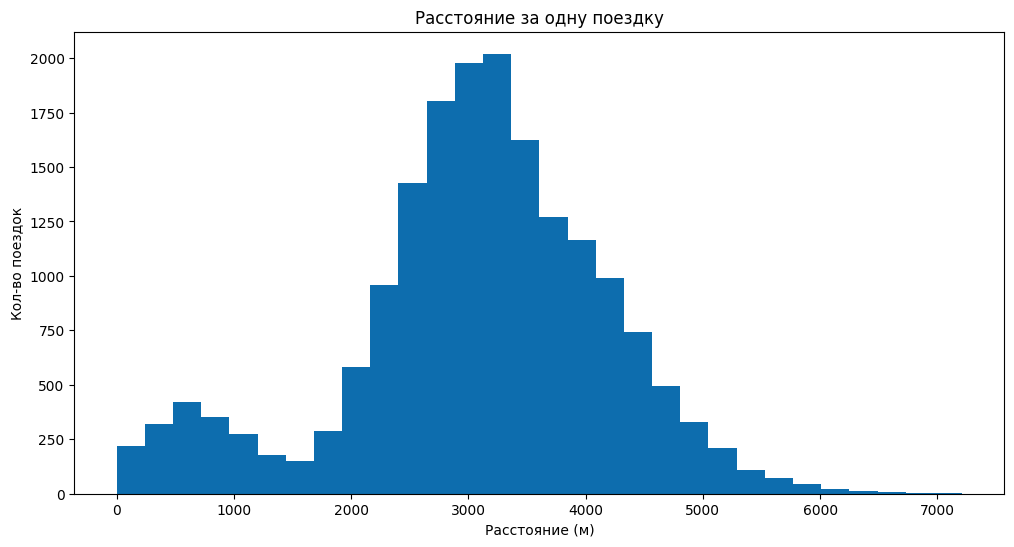

In [25]:
rides_df['distance'].plot(kind='hist', bins=30, color=COLOR[5], figsize=(12, 6))

plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Кол-во поездок');

In [26]:
rides_df['distance'].describe()

,distance
count,18068.000000
mean,3070.659976
std,1116.831209
min,0.855683
25%,2543.226360
50%,3133.609994
75%,3776.222735
max,7211.007745


Доля поездок до 1,5 км:

In [27]:
rides_df.query('distance < 1500')['distance'].count() / rides_df['distance'].count()

0.09940225813593093

Среднее расстояние поездки составляет около 3100 метров, максимальная поездка была 7211 метров. На графике можно наблюдать 2 пика. Основной около среднего в 3 км, и не большой до 1,5 км. Это может говорить о том, что регулярно, в 10% случаев, самокат используется только для коротких поездок, например как транспорт "последней мили", - способ добраться от остановки общественного транспорта до точки назначения.

### Продолжительность поездок

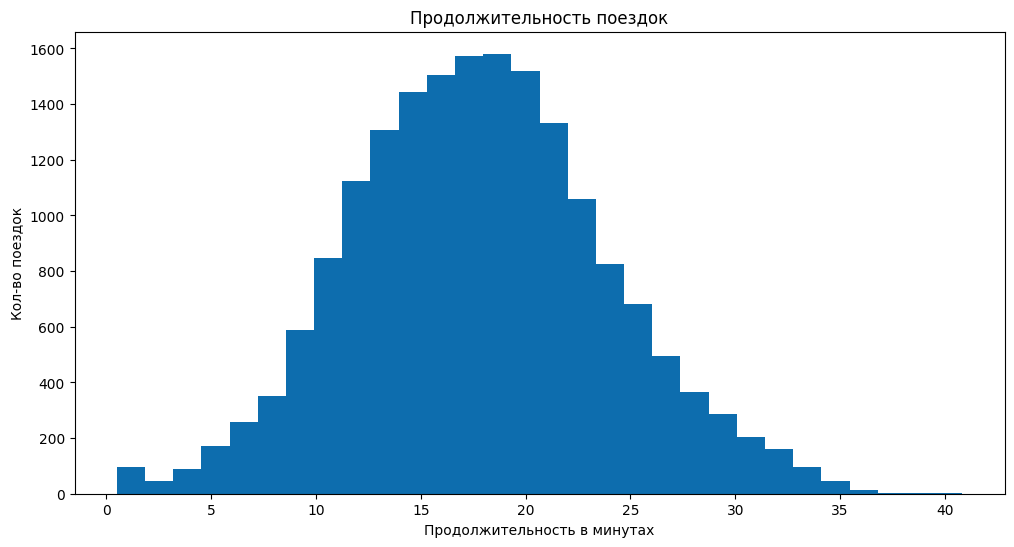

In [28]:
rides_df['duration'].plot(kind='hist', bins=30, color=COLOR[5], figsize=(12, 6))

plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность в минутах')
plt.ylabel('Кол-во поездок');

In [29]:
rides_df['duration'].describe()

,duration
count,18068.000000
mean,17.805011
std,6.091051
min,0.500000
25%,13.597563
50%,17.678395
75%,21.724800
max,40.823963


Видно не большой всплеск ближе к 0 минутам:

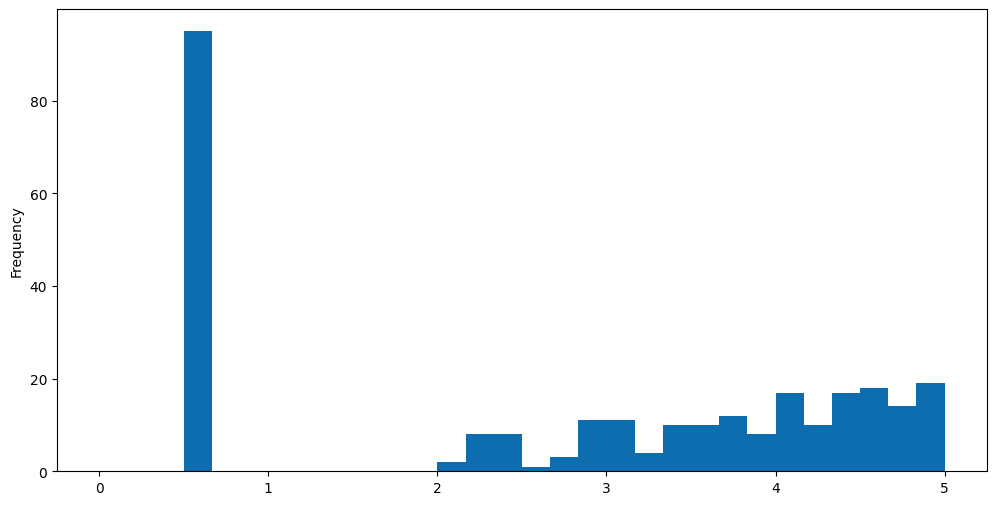

In [30]:
rides_df['duration'].plot(kind='hist',
                          bins=30,
                          color=COLOR[5],
                          figsize=(12, 6),
                          range=(0, 5));

Средняя поездка на самокате длиться 17 минут, максимальная поезда была 40 минут. Наблюдается небольшой всплеск у 0 минут. Можно предположить, что пользователи завершают поездки до 1 минут из-за технических неисправностей самоката.  

### Вывод

В ходе исследовательского анализа данных было выявлено:

- Большенство пользователей живут в городах юга России, Сибири и на Урале. Москва находиться на последнем месте по количеству пользователей.
- Платная подписка имеется почти у половины пользователей (46%).
- Средний возраст пользователей около 25 лет.
- Среднее расстояние поездки составляет около 3100 метров. 10% поездок, регулярно совершаются на короткие расстояния, возможно самокат используют как транспорт "последней мили".
- Средняя поездка на самокате длиться 17 минут. Есть небольшой всплеск у 0 минут, возможно связанный, с техническими неисправностями самоката.


## Шаг 4. Объединение данных

### Объединение датафреймов

In [31]:
data = rides_df.merge(users_df, on='user_id')
data = data.merge(subs_df, on='subscription_type')
data

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
18064,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
18065,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
18066,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int32         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


### Создание датафреймов

Данные о пользователях без подписки:

In [33]:
users_subs_free = data.query('subscription_type == "free"')
users_subs_free.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int32         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


Данные о пользователях с подпиской:

In [34]:
users_subs_ultra = data.query('subscription_type == "ultra"')
users_subs_ultra.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int32         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


### Визуализация информации для пользователей обеих категорий

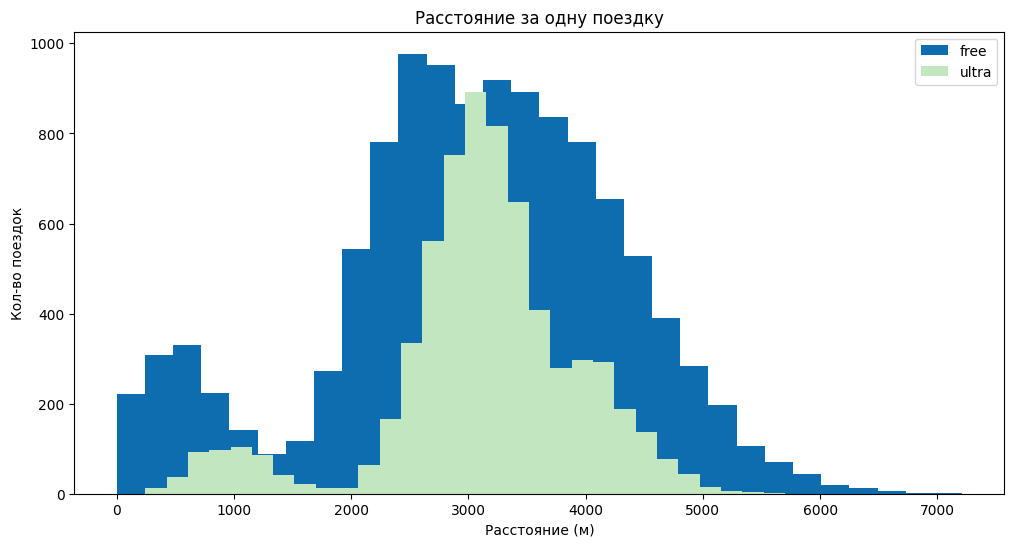

In [35]:
free = users_subs_free['distance']
ultra = users_subs_ultra['distance']
plt.figure(figsize=(12, 6))
plt.hist(free, label='free', bins=30, color=COLOR[5])
plt.hist(ultra, label='ultra', bins=30, color=COLOR[1])
plt.title('Расстояние за одну поездку')
plt.xlabel('Расстояние (м)')
plt.ylabel('Кол-во поездок')
plt.legend();

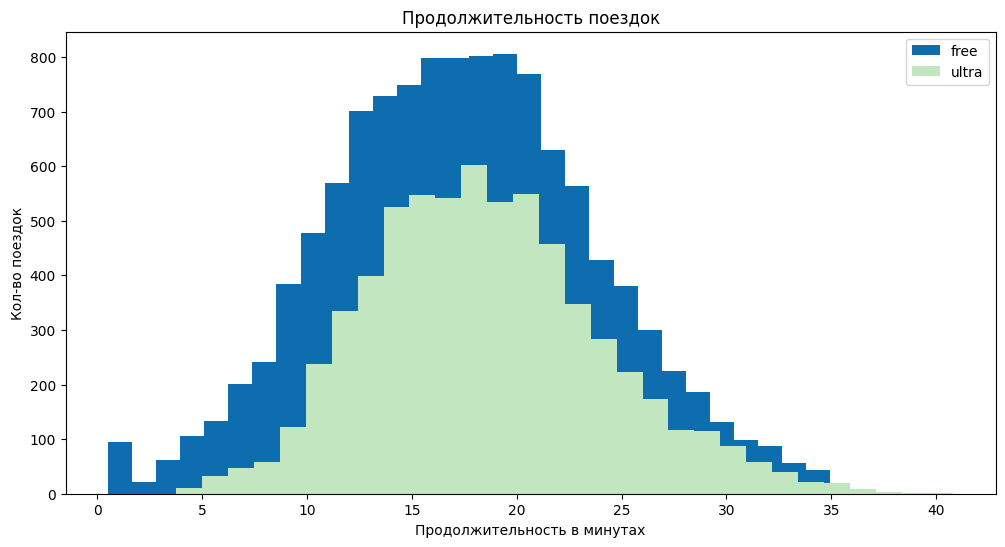

In [36]:
free = users_subs_free['duration']
ultra = users_subs_ultra['duration']
plt.figure(figsize=(12, 6))
plt.hist(free, label='free', bins=30, color=COLOR[5])
plt.hist(ultra, label='ultra', bins=30, color=COLOR[1])
plt.title('Продолжительность поездок')
plt.xlabel('Продолжительность в минутах')
plt.ylabel('Кол-во поездок')
plt.legend();

### Вывод

На данном шаге были объеденены все три датафрейма, на основе нового датафрейма были созданы два новых c данными о пользователях с подпиской и без. На основе двух новых датафреймов была сделана визуализация данных о расстоянии и времени поездок.
На визуализации видно, что пользователи без подписки чаще совершают короткие поездки до 1,5 км, пользователей с подпиской как правило преодолевают меньшее расстоянее, однако за сопостовимое время, возможно это связанно с тем, что пользователи с подпиской не спешат завершить аренду как можно быстрее из-за более дешевого тарифа. Так же среди пользователей с подпиской не наблюдается аномально коротких поездок до 1 минуты.

## Шаг 5. Подсчёт выручки

### Создайте датафрейм с агрегированными данными о поездках

In [37]:
users_income = data.pivot_table(
    index=['user_id', 'month', 'subscription_type'],
    values=['distance', 'duration'], aggfunc=['sum','count']
    )

users_income.columns = ['total_distance', 'total_duration', 'total_trips', '_']
users_income = users_income.drop('_', axis=1)
users_income.reset_index(inplace= True)
users_income.head()

,user_id,month,subscription_type,total_distance,total_duration,total_trips
0,1,1,ultra,7027.511294,41.416640,2
1,1,4,ultra,754.159807,6.232113,1
2,1,8,ultra,6723.470560,44.776802,2
3,1,10,ultra,5809.911100,31.578017,2
4,1,11,ultra,7003.499363,53.397424,3


### Добавление столбца с помесячной выручкой

In [38]:
def month_income(row):
    if row['subscription_type'] == 'ultra':
        res = (row['total_duration'] * 6) + 199
    else:
        res = (row['total_duration'] * 8) + row['total_trips'] * 50
    return math.ceil(res)

In [39]:
users_income['total_income'] = users_income.apply(month_income, axis=1)

In [40]:
users_income

,user_id,month,subscription_type,total_distance,total_duration,total_trips,total_income
0,1,1,ultra,7027.511294,41.416640,2,448
1,1,4,ultra,754.159807,6.232113,1,237
2,1,8,ultra,6723.470560,44.776802,2,468
3,1,10,ultra,5809.911100,31.578017,2,389
4,1,11,ultra,7003.499363,53.397424,3,520
...,...,...,...,...,...,...,...
11326,1534,6,free,3409.468534,24.812678,2,299
11327,1534,8,free,7622.453034,47.205960,2,478
11328,1534,9,free,4928.173852,22.560373,1,231
11329,1534,11,free,13350.015305,76.342174,4,811


## Шаг 6. Проверка гипотез

##### Проверка гипотезы №1

Тратят ли пользователи с подпиской больше времени на поездки?

Н0: Среднее время поездки пользователей с подпиской и без подписки одинаковое.<br>
Н1: Среднее время поездки пользователей с подпиской больше.

In [41]:
free_users = users_subs_free['duration']
ultra_users = users_subs_ultra['duration']

print(f'Среднее время поездки без подписки: {np.mean(free_users)}')
print(f'Среднее время поездки с подпиской: {np.mean(ultra_users)}')


alpha = 0.05

results = st.ttest_ind(
    ultra_users,
    free_users,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее время поездки без подписки: 17.39090929866399
Среднее время поездки с подпиской: 18.54198516280583
p-значение: 1.2804098316645618e-34
Отвергем нулевую гипотезу


Нулевая гипотеза отвергнута в пользу альтернативной, значит среднее время поездки пользователей с подпиской больше.

###  Проверка гипотезы №2

Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

Н0: Среднее расстояние поездки пользователей с подпиской равно 3130 метров.<br>
Н1: Среднее расстояние поездки пользователей с подпиской больше 3130 метров.

In [42]:
distance_ultra_users = users_subs_ultra['distance']

print(f'Среднее расстояние одной поездки с подпиской: {np.mean(distance_ultra_users)}')

value = 3130
alpha = 0.05

results = st.ttest_1samp(
    distance_ultra_users,
    value,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее расстояние одной поездки с подпиской: 3115.4453880370247
p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Нулевая гипотеза не отвергнута, значит мы не можем утверждать, что среднее расстояние преодолеваемое пользователями с подпиской превышает 3130 метров.

### Проверка гипотезы №3

Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Н0: Помесячная выручка от пользователей с подпиской и без подписки равна.<br> Н1: Помесячная выручка от пользователей с подпиской выше.

In [43]:
free_income = users_income[users_income['subscription_type'] == 'free']['total_income']
ultra_income = users_income[users_income['subscription_type'] == 'ultra']['total_income']

print(f'Средний доход без подписки: {np.mean(free_income)}')
print(f'Средний доход с подпиской: {np.mean(ultra_income)}')


alpha = 0.05

results = st.ttest_ind(
    ultra_income,
    free_income,
    alternative='greater'
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


Средний доход без подписки: 322.32362459546925
Средний доход с подпиской: 359.02978160158835
p-значение: 2.758832300750934e-37
Отвергем нулевую гипотезу


P-значение стремится к нулю, значит, нулевая гипотеза отвергнута, это означает, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Вывод

В ходе проверок гипотез было выявлено следующее:
- Среднее время поездки пользователей с подпиской больше.
- Нельзя утверждать, что среднее расстояние преодолеваемое пользователями с подпиской превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

## Общий вывод

Были получены три датафрейма:
- `users_df` со списком пользоватей,
- `rides_df` со списком поездок,
- `subs_df` с вариантами подписок.

Пропусков в данных не обнаружено. Столбец `date` датафрейма `rides_df` был приведен к типу данных `datetime`. Были удалены дубликаты в фрейме `users_df`, вызванные, судя по всему, ошибкой при выгрузке или передаче данных, стоит обратить на это внимание.

В ходе исследовательского анализа данных было выявлено:
- Большенство пользователей живут в городах юга России, Сибири и на Урале. Москва находиться на последнем месте по количеству пользователей.
- Платная подписка имеется почти у половины пользователей (46%).
- Средний возраст пользователей около 25 лет.
- Среднее расстояние поездки составляет около 3100 метров. 10% поездок, регулярно совершаются на короткие расстояния, возможно самокат используют как транспорт "последней мили".
- Средняя поездка на самокате длиться 17 минут. Есть небольшой всплеск у 0 минут, возможно связанный, с техническими неисправностями самоката.

При сравнении пользователей с подпиской и без выявлено, что пользователи без подписки чаще совершают короткие поездки до 1,5 км, пользователей с подпиской как правило преодолевают меньшее расстоянее, однако за сопостовимое время, возможно это связанно с тем, что пользователи с подпиской не спешат завершить аренду как можно быстрее из-за более дешевого тарифа. Так же среди пользователей с подпиской не наблюдается аномально коротких поездок до 1 минуты.

В ходе проверок гипотез было выявлено следующее:
- Среднее время поездки пользователей с подпиской больше.
- Среднее расстояние преодолеваемое пользователями с подпиской не превышает 3130 метров.
- Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Следует обратить внимание на аномально короткие (до 1 минуты) поездки пользователей без подписки, так же имеет смысл сравнить активность пользователей по городам, преодолеваемые расстояния, соотношение количества пользователей с подпиской и без, так как разные города имеют разные размер, инфраструктуру, уровень платежеспособности клиентов и разный климат, все эти показатели могут сильно влиять на поведение пользователей.